# Autoencoder with F-MNIST
This notebook trains an [autoencoder](https://en.wikipedia.org/wiki/Autoencoder) on the F-MNIST dataset and exports the model and weights via FluxJS.  This roughly follows the example from the [Flux model zoo](https://github.com/FluxML/model-zoo) and the MLP notebook.

In [1]:
using Flux
using Flux: onehotbatch, throttle, @epochs, mse
using BSON
using Base.Iterators: repeated, partition
using FluxJS
using MLDatasets # FashionMNIST
using ColorTypes: N0f8, Gray
using Images

In [2]:
const Img = Matrix{Gray{N0f8}}

function prepare_train()
    # load full training set
    train_x, train_y = FashionMNIST.traindata() # 60_000

    trainrange = 1:60_000 # 1:60_000
    imgs = Img.([train_x[:,:,i] for i in trainrange])
    
    # Stack into 60 batches of 1k images
    X = [float(hcat(vec.(imgs)...)) for imgs in partition(imgs, 1000)] |> gpu
    X
end

X = prepare_train();

In [3]:
N = 32 # Size of the encoding
# leakyrelu currently can't be exported by FluxJS when used inside a Chain
encoder = Chain(Dense(28^2, 4*N, relu), Dense(4*N, N, relu)) |> gpu
decoder = Chain(Dense(N, 4*N, relu), Dense(4*N, 28^2)) |> gpu

Chain(Dense(32, 128, NNlib.relu), Dense(128, 784))

In [4]:
m = Chain(encoder, decoder)
loss(x) = mse(m(x), x)

# Looking at the loss is booring -- let's use a visual callback function
img(x::Vector) = Gray.(reshape(clamp.(x, 0, 1), 28, 28))
evalcb = 
    throttle(() -> display(
       hcat([vcat(img(X[1][:,i]), img(m(X[1][:,i]).data)) 
                for i in rand(collect(1:1000), 6)]...)
    ), 30)
opt = ADAM(params(m))
# opt = SGD(params(m), 0.1)

(::#71) (generic function with 1 method)

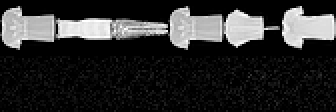

INFO: Epoch 1
INFO: Epoch 2
INFO: Epoch 3


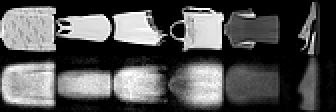

INFO: Epoch 4
INFO: Epoch 5
INFO: Epoch 6


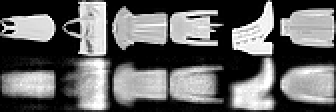

INFO: Epoch 7
INFO: Epoch 8
INFO: Epoch 9


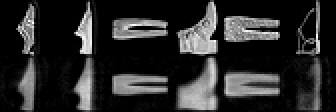

INFO: Epoch 10
INFO: Epoch 11
INFO: Epoch 12


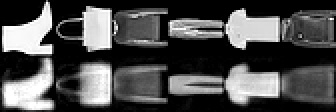

INFO: Epoch 13
INFO: Epoch 14
INFO: Epoch 15


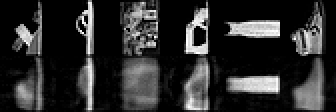

INFO: Epoch 16
INFO: Epoch 17
INFO: Epoch 18


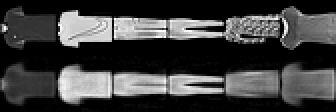

INFO: Epoch 19
INFO: Epoch 20
INFO: Epoch 21


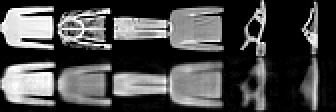

INFO: Epoch 22
INFO: Epoch 23
INFO: Epoch 24


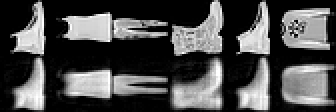

INFO: Epoch 25
INFO: Epoch 26
INFO: Epoch 27


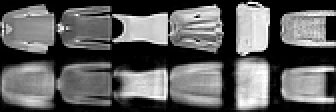

INFO: Epoch 28
INFO: Epoch 29
INFO: Epoch 30


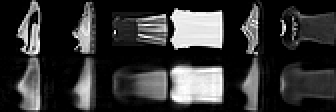

INFO: Epoch 31
INFO: Epoch 32
INFO: Epoch 33


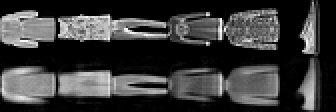

INFO: Epoch 34
INFO: Epoch 35
INFO: Epoch 36


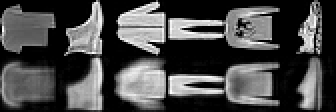

INFO: Epoch 37
INFO: Epoch 38
INFO: Epoch 39


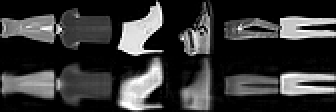

INFO: Epoch 40
INFO: Epoch 41
INFO: Epoch 42


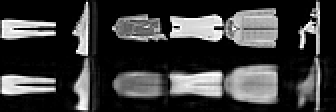

INFO: Epoch 43
INFO: Epoch 44
INFO: Epoch 45


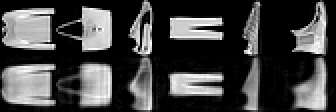

INFO: Epoch 46
INFO: Epoch 47
INFO: Epoch 48


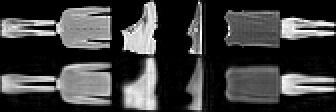

INFO: Epoch 49
INFO: Epoch 50


In [5]:
@epochs 50 Flux.train!(loss, zip(X), opt, cb = evalcb)

We now have a way of encoding the information about F-MNIST images in a length-32 vector and recovering it back to an image.  It turns out that we don't use that vector very efficently -- several values are always zero for any input image.  

I don't know of any good ways to visualize distributions of length-32 vectors, but we can do PCA on all of them and plot a sampling of images along their three principle components.

In [16]:
using PlotlyJS, MultivariateStats
samp = encoder(X[1][:,1:1000]).data
println(size(samp))
M = fit(PCA, samp; maxoutdim=3)
Y = transform(M, samp)
size(Y)

(32, 1000)


(3, 1000)

In [24]:
plot(scatter(x=Y[1,:], y=Y[2,:], marker_color=Y[3,:], text=Y[3,:], mode="markers"), Layout())

The different input images are not distributed in any recognizable way in this plot, although there's some clear clustering along the 2nd principle component, which roughly corresponds to the "shirt-shoe" axis.  

We can see this by reconstructing images from the first two principle components:

,,,,,,,
,,,,,,,
,,,,,,,
,,,,,,,
,,,,,,,
,,,,,,,
,,,,,,,

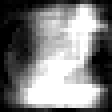
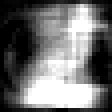
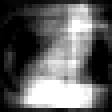
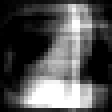
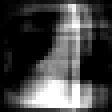
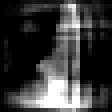
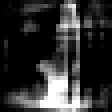
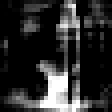
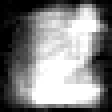
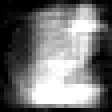
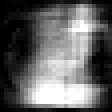
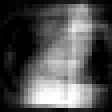
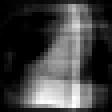
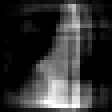
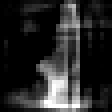
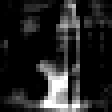
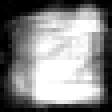
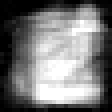
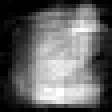
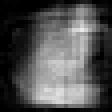
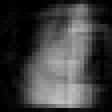
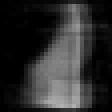
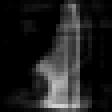
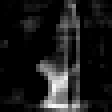
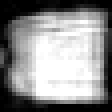
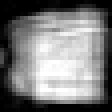
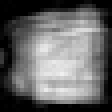
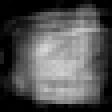
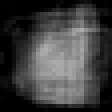
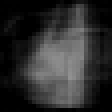
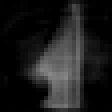
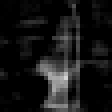
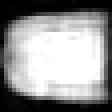
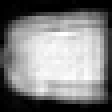
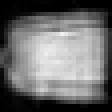
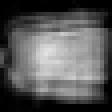
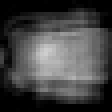
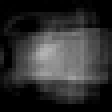
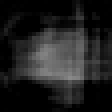
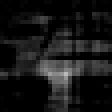
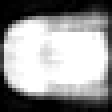
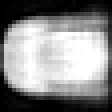
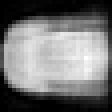
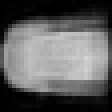
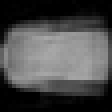
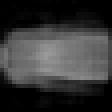
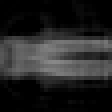
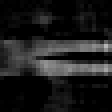
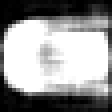
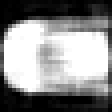
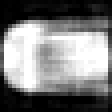
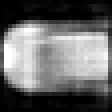
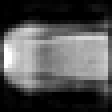
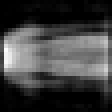
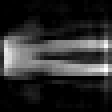
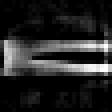

In [11]:
img(decoder(reconstruct(M, Y[:,1])).data)
hcat([
        vcat([img(decoder(reconstruct(M, [p1, p2])).data)
                for p1 in -12.0:3:10
                ])
        for p2 in -8.0:2:5
        ]...)

We can also check and make sure that we didn't somehow make a general image compression scheme by feeding in atypical inputs.  Here we use the normal MNIST dataset.

In [12]:
function prepare_M()
    # load full training set
    train_x, train_y = MLDatasets.MNIST.traindata() # 60_000

    trainrange = 1:100 # 1:60_000
    imgs = Img.([train_x[:,:,i] for i in trainrange])
    # Stack into 1 batch of 100 images
    X = [float(hcat(vec.(imgs)...)) for imgs in partition(imgs, 100)] |> gpu
    X
end

MX = prepare_M();

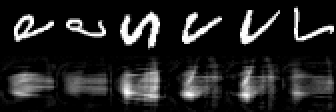

In [13]:
display(
       hcat([vcat(img(MX[1][:,i]), img(m(MX[1][:,i]).data)) 
                for i in rand(collect(1:100), 6)]...)
    )

Lastly, we can export the two halves of the model and their weights.  

In [11]:
@code_js decoder(zeros(Float32,32))

let model = (function () {
  let math = dl.ENV.math;
  function model(ostrich) {
    return math.add(math.matrixTimesVector(model.weights[0], ostrich), model.weights[1]);
  };
  model.weights = [];
  return model;
})();
flux.fetchWeights("model.bson").then((function (ws) {
  return model.weights = ws;
}));


In [14]:
FluxJS.compile("decoder", decoder, zeros(Float32,32))

In [26]:
FluxJS.compile("encoder", encoder, zeros(Float32,28*28))